In [1]:
!python -m pip install -q amazon-textract-response-parser --upgrade
!python -m pip install -q amazon-textract-caller --upgrade
!python -m pip install -q amazon-textract-prettyprinter --upgrade

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
import boto3
import sagemaker
import os
from io import BytesIO
from PIL import Image
from IPython.display import Image, display, JSON, IFrame
from trp import Document
from PIL import Image as PImage, ImageDraw
import time
from IPython.display import IFrame


## Document Validation & completeness check

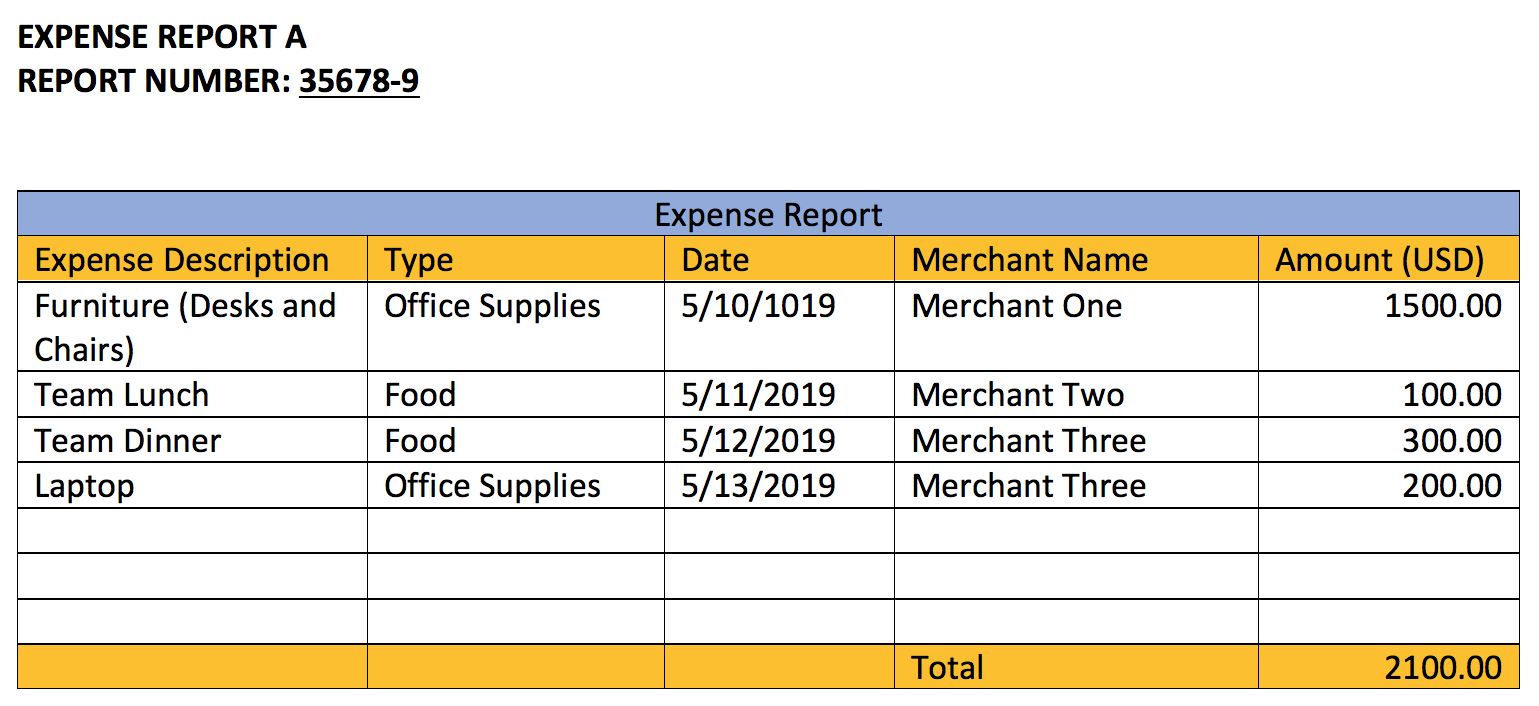

In [4]:
# Document
documentName = "expense.png"
display(Image(filename=documentName))


In [9]:
def isFloat(input):
  try:
    float(input)
  except ValueError:
    return False
  return True

In [10]:
# Call Amazon Textract
# Read document content
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Amazon Textract client
textract = boto3.client('textract')
    
response = textract.analyze_document(
    Document={'Bytes': imageBytes},
    FeatureTypes=["TABLES"])


doc = Document(response)

warning = ""
for page in doc.pages:
    for table in page.tables:
        for r, row in enumerate(table.rows):
            itemName  = ""
            for col, cell in enumerate(row.cells):
                
                if(col == 0):
                    itemName = cell.text
              
                elif(col == 4 and isFloat(cell.text)):
                    expense_value = float(cell.text)
                
                    if(expense_value > 1000):
                        warning += "{} amount is greater than $1000.".format(itemName)
if(warning):
    print("\nReview required:\n==================\n" + warning)


Review required:
Furniture (Desks and Chairs)  amount is greater than $1000. amount is greater than $1000.


### Document Validation with Form type

### Sensitive data redaction

In [11]:
import pandas as pd
import webbrowser, os
import json
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader
import uuid
import time
import io
from io import BytesIO
import sys
from pprint import pprint

from IPython.display import Image, display
from PIL import Image as PImage, ImageDraw

In [12]:

region = boto3.Session().region_name

role = get_execution_role()
print(role)

bucket = sagemaker.Session().default_bucket()

prefix = "pii-detection-redaction"
bucket_path = "https://s3-{}.amazonaws.com/{}".format(region, bucket)

arn:aws:iam::044573436347:role/text-cm-SagemakerRole-SXXWU3NUWVCX


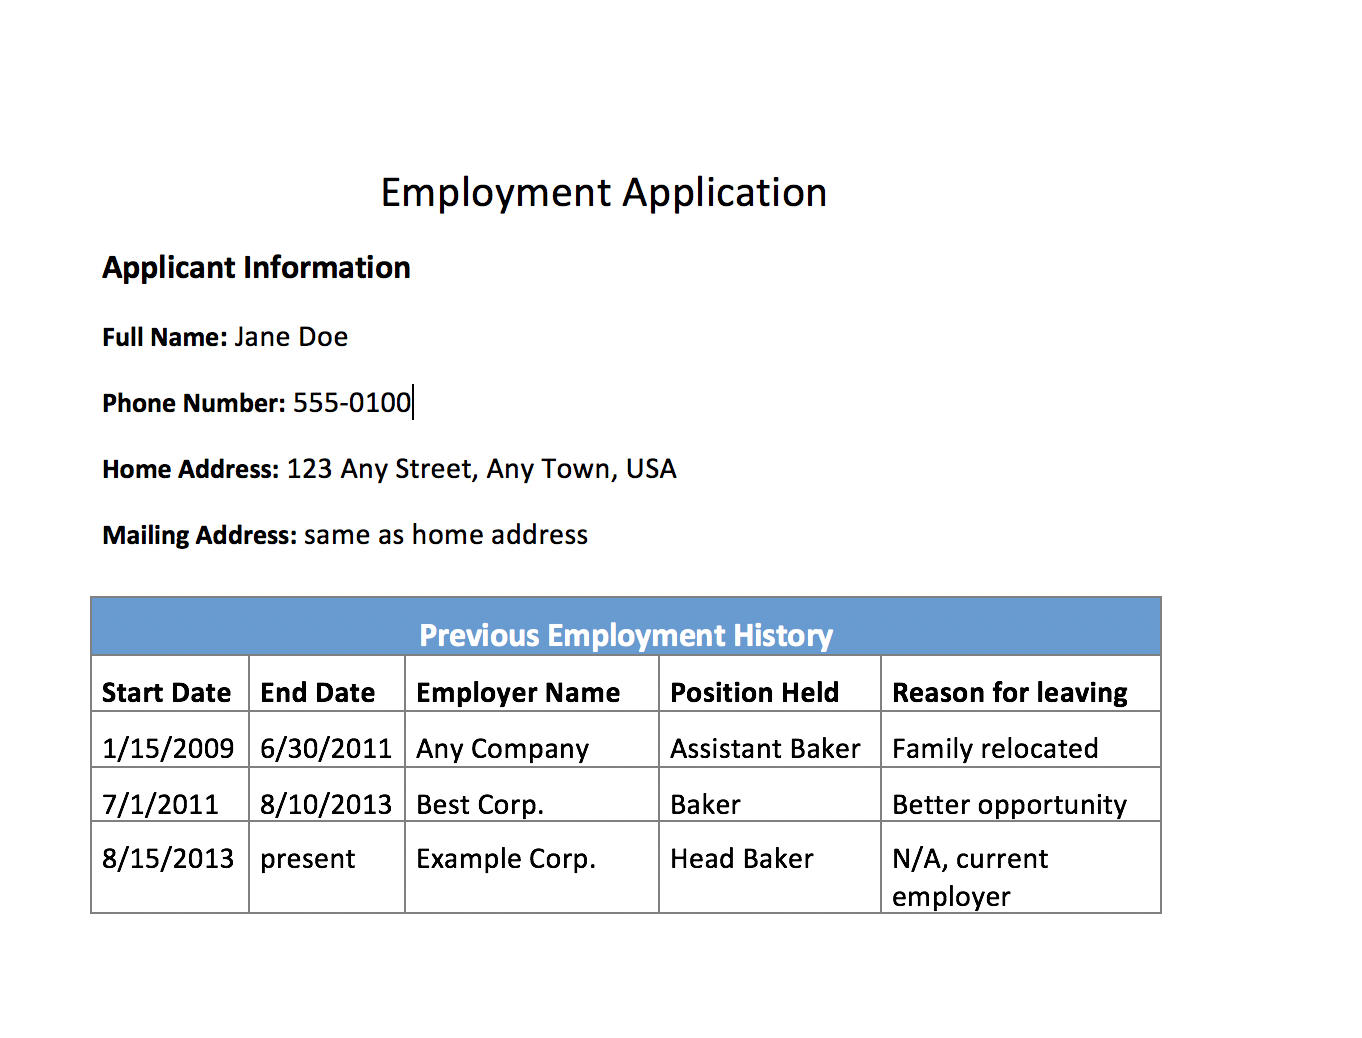

In [22]:
# Document
documentName = "employmentapp.png"

display(Image(filename=documentName))

In [13]:

with open(documentName, 'rb') as file:
            img_test = file.read()
            bytes_test = bytearray(img_test)
            print('Image loaded', documentName)

    # process using image bytes
response = textract.detect_document_text(Document={'Bytes': bytes_test})

Image loaded expense.png


In [14]:
#Extract key values

from trp import Document


doc = Document(response)
page_string = ''
for page in doc.pages:
    # Print lines and words
       
        for line in page.lines:
            page_string += str(line.text)
print(page_string)

EXPENSE REPORT AREPORT NUMBER: 35678-9Expense ReportExpense DescriptionTypeDateMerchant NameAmount (USD)Furniture (Desks andOffice Supplies5/10/1019Merchant One1500.00Chairs)Team LunchFood5/11/2019Merchant Two100.00Team DinnerFood5/12/2019Merchant Three300.00LaptopOffice Supplies5/13/2019Merchant Three200.00Total2100.00


#### Save the extracted text into text file and uplaod to Amazon S3 bucket

In [15]:
# Lets get the  data into a text file
text_filename = 'pii_data.txt'
doc = Document(response)
with open(text_filename, 'w', encoding='utf-8') as f:
    for page in doc.pages:
    # Print lines and words
        page_string = ''
        for line in page.lines:
            #print((line.text))
            page_string += str(line.text)
        #print(page_string)
        f.writelines(page_string + "\n")

In [16]:
import sagemaker

# Load the documents locally for later analysis
with open(text_filename, "r") as fi:
    raw_texts = [line.strip() for line in fi.readlines()]
data_bucket = sagemaker.Session().default_bucket()

s3 = boto3.resource('s3')
s3.Bucket(data_bucket).upload_file("pii_data.txt", "identified-data/pii_data.txt")
#print(sagemaker.Session().default_bucket())

InputS3URI = "s3://"+data_bucket+"/identified-data/pii_data.txt"
OutputS3URI = "s3://"+data_bucket+"/non_pii_data.txt"

print(InputS3URI)

s3://sagemaker-us-east-1-044573436347/identified-data/pii_data.txt


#### Mask PII using Amazon Comprehend PII Analysis Job

In [17]:
comprehend = boto3.client(service_name='comprehend')

role = sagemaker.get_execution_role()
response = comprehend.start_pii_entities_detection_job(
    InputDataConfig={
        'S3Uri': InputS3URI,
        'InputFormat': 'ONE_DOC_PER_FILE'
    },
    OutputDataConfig={
        'S3Uri': OutputS3URI
       
    },
    Mode='ONLY_REDACTION',
    RedactionConfig={
        'PiiEntityTypes': [
           'ALL',
        ],
        'MaskMode': 'MASK',
        'MaskCharacter': '*'
    },
    DataAccessRoleArn = role,
    JobName="job1",
    LanguageCode='en',
    
)

In [18]:
# Get the job ID
events_job_id = response['JobId']
job = comprehend.describe_pii_entities_detection_job(JobId=events_job_id)
print(job)

{'PiiEntitiesDetectionJobProperties': {'JobId': 'a5511866d7466c7d389c566d9e9c03b6', 'JobArn': 'arn:aws:comprehend:us-east-1:044573436347:pii-entities-detection-job/a5511866d7466c7d389c566d9e9c03b6', 'JobName': 'job1', 'JobStatus': 'IN_PROGRESS', 'SubmitTime': datetime.datetime(2022, 9, 23, 4, 30, 35, 634000, tzinfo=tzlocal()), 'InputDataConfig': {'S3Uri': 's3://sagemaker-us-east-1-044573436347/identified-data/pii_data.txt', 'InputFormat': 'ONE_DOC_PER_FILE'}, 'OutputDataConfig': {'S3Uri': 's3://sagemaker-us-east-1-044573436347/non_pii_data.txt/044573436347-PII-a5511866d7466c7d389c566d9e9c03b6/output/'}, 'RedactionConfig': {'PiiEntityTypes': ['ALL'], 'MaskMode': 'MASK', 'MaskCharacter': '*'}, 'LanguageCode': 'en', 'DataAccessRoleArn': 'arn:aws:iam::044573436347:role/text-cm-SagemakerRole-SXXWU3NUWVCX', 'Mode': 'ONLY_REDACTION'}, 'ResponseMetadata': {'RequestId': 'f3a3e3c0-7a88-4bde-ad46-79d8429de68c', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'f3a3e3c0-7a88-4bde-ad46-79

In [19]:
from time import sleep
# Get current job status
job = comprehend.describe_pii_entities_detection_job(JobId=events_job_id)
print(job)
# Loop until job is completed
waited = 0
timeout_minutes = 10
while job['PiiEntitiesDetectionJobProperties']['JobStatus'] != 'COMPLETED':
    sleep(60)
    waited += 60
    assert waited//60 < timeout_minutes, "Job timed out after %d seconds." % waited
    job = comprehend.describe_pii_entities_detection_job(JobId=events_job_id)
print(response)

{'PiiEntitiesDetectionJobProperties': {'JobId': 'a5511866d7466c7d389c566d9e9c03b6', 'JobArn': 'arn:aws:comprehend:us-east-1:044573436347:pii-entities-detection-job/a5511866d7466c7d389c566d9e9c03b6', 'JobName': 'job1', 'JobStatus': 'IN_PROGRESS', 'SubmitTime': datetime.datetime(2022, 9, 23, 4, 30, 35, 634000, tzinfo=tzlocal()), 'InputDataConfig': {'S3Uri': 's3://sagemaker-us-east-1-044573436347/identified-data/pii_data.txt', 'InputFormat': 'ONE_DOC_PER_FILE'}, 'OutputDataConfig': {'S3Uri': 's3://sagemaker-us-east-1-044573436347/non_pii_data.txt/044573436347-PII-a5511866d7466c7d389c566d9e9c03b6/output/'}, 'RedactionConfig': {'PiiEntityTypes': ['ALL'], 'MaskMode': 'MASK', 'MaskCharacter': '*'}, 'LanguageCode': 'en', 'DataAccessRoleArn': 'arn:aws:iam::044573436347:role/text-cm-SagemakerRole-SXXWU3NUWVCX', 'Mode': 'ONLY_REDACTION'}, 'ResponseMetadata': {'RequestId': '7b924f72-b5d3-4de5-91fb-969f48c181f4', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '7b924f72-b5d3-4de5-91fb-96

#### View redacted document

In [21]:
filename="pii_data.txt"
output_data_s3_file = job['PiiEntitiesDetectionJobProperties']['OutputDataConfig']['S3Uri'] + filename + '.out'
print(output_data_s3_file)

s3://sagemaker-us-east-1-044573436347/non_pii_data.txt/044573436347-PII-a5511866d7466c7d389c566d9e9c03b6/output/pii_data.txt.out


In [22]:
# The output filename is the input filename + ".out"
s3_client = boto3.client(service_name='s3')
filename="pii_data.txt"
output_data_s3_file = job['PiiEntitiesDetectionJobProperties']['OutputDataConfig']['S3Uri'] + filename + '.out'
print(output_data_s3_file)
output_data_s3_filepath=output_data_s3_file.split("//")[1].split("/")[1]+"/"+output_data_s3_file.split("//")[1].split("/")[2]+"/"+output_data_s3_file.split("//")[1].split("/")[3]+"/"+output_data_s3_file.split("//")[1].split("/")[4]
print(output_data_s3_filepath)

f = BytesIO()
s3_client.download_fileobj(bucket, output_data_s3_filepath, f)
f.seek(0)
print(f.getvalue())

s3://sagemaker-us-east-1-044573436347/non_pii_data.txt/044573436347-PII-a5511866d7466c7d389c566d9e9c03b6/output/pii_data.txt.out
non_pii_data.txt/044573436347-PII-a5511866d7466c7d389c566d9e9c03b6/output/pii_data.txt.out
b'EXPENSE REPORT AREPORT NUMBER: 35678-9Expense ReportExpense DescriptionTypeDateMerchant NameAmount (USD)Furniture (Desks andOffice Supplies5/10/1019Merchant One1500.00Chairs)Team LunchFood5/11/2019Merchant Two100.00Team DinnerFood5/12/2019Merchant Three300.00LaptopOffice Supplies5/13/2019Merchant Three200.00Total2100.00\n\n'


### Redaction with structural element

In [23]:


# Document
documentName = "employmentapp.png"


# Call Amazon Textract
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())



In [24]:
# Call Amazon Textract
response = textract.analyze_document(Document={'Bytes': imageBytes}, FeatureTypes=["FORMS"])

#print(response)

doc = Document(response)

Redacting => Key: Home Address:, Value: 123 Any Street, Any Town, USA
Redacting => Key: Mailing Address:, Value: same as home address


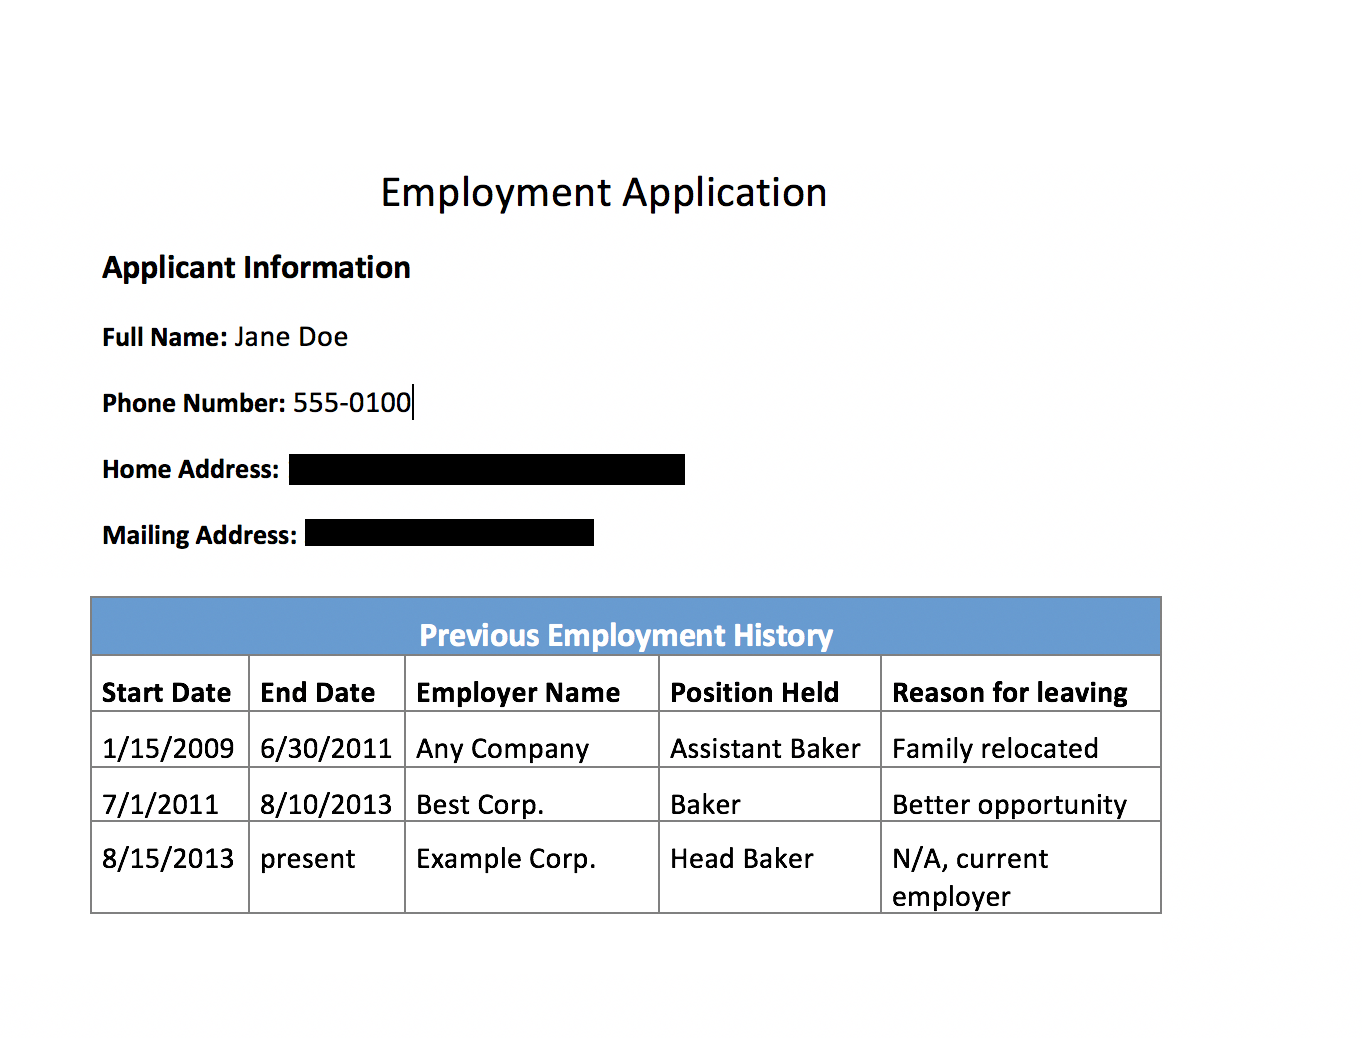

In [25]:
# Redact document
img = PImage.open(documentName)

width, height = img.size

if(doc.pages):
    page = doc.pages[0]
    for field in page.form.fields:
        if(field.key and field.value and "address" in field.key.text.lower()):
            print("Redacting => Key: {}, Value: {}".format(field.key.text, field.value.text))
            
            x1 = field.value.geometry.boundingBox.left*width
            y1 = field.value.geometry.boundingBox.top*height-2
            x2 = x1 + (field.value.geometry.boundingBox.width*width)+5
            y2 = y1 + (field.value.geometry.boundingBox.height*height)+2

            draw = ImageDraw.Draw(img)
            draw.rectangle([x1, y1, x2, y2], fill="Black")

outputDocumentName = "redacted-{}".format(documentName)
img.save(outputDocumentName)
display(Image(filename=outputDocumentName))

### Human Review

In [26]:
uniqueId = str(uuid.uuid4())
human_loop_unique_id = uniqueId + '1'
print(human_loop_unique_id)

humanLoopConfig = {
    'FlowDefinitionArn':"arn:aws:sagemaker:us-east-1:044573436347:flow-definition/idpa2i1",
    'HumanLoopName':human_loop_unique_id, 
    'DataAttributes': { 'ContentClassifiers': [ 'FreeOfPersonallyIdentifiableInformation' ]}
}

afd4d4fd-fcba-470e-b692-8cfc4363a1a51


In [27]:
def analyze_document_with_a2i(document_name, bucket):
    response = textract.analyze_document(
        Document={'S3Object': {'Bucket': bucket, 'Name': document_name}},
        FeatureTypes=["TABLES", "FORMS"], 
        HumanLoopConfig=humanLoopConfig
    )
    return response

### End